In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import cufflinks as cf
cf.go_offline()

In [2]:
url_ty="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
#url_1="https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
death_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
df = pd.read_csv(url_ty, error_bad_lines = False)
deathf = pd.read_csv(death_url, error_bad_lines = False)

In [3]:
date_cols = [x for x in df.columns if x[-1]=="0"]
death_date_cols = [x for x in deathf.columns if x[-1]=="0"]

#confirmed time series

counties = df.copy()  
confirmed = df.groupby("Province_State")[date_cols].sum()
confirmed_reset = df.groupby("Province_State")[date_cols].sum().reset_index()

#death time series

death = deathf.groupby("Province_State")[death_date_cols].sum() 
death_reset = deathf.groupby("Province_State")[death_date_cols].sum().reset_index()

#grab state populations from death data and merge into confirmed cases

county_pop = deathf["Population"]
state_pop = deathf.groupby("Province_State")["Population"].sum().T
confirmed_w_pop = pd.merge(confirmed, pd.DataFrame(state_pop), left_index=True, right_index=True)
counties_w_pop = pd.merge(counties, pd.DataFrame(county_pop), left_index = True, right_index = True)

#divide each daily cases in time series by the states population

confirmed_norm = confirmed_w_pop.iloc[:,:-1].div(confirmed_w_pop["Population"], axis=0)
counties_norm = counties_w_pop.iloc[:,11:-1].div(counties_w_pop["Population"], axis=0)
temp = pd.merge(pd.DataFrame(counties_w_pop["Admin2"]), pd.DataFrame(counties_w_pop["Province_State"]), left_index = True, right_index = True)
counties_norm = pd.merge(temp, counties_norm, left_index = True, right_index = True).dropna()

death_norm = death.iloc[:,:-1].div(confirmed_w_pop["Population"], axis=0)
death_norm = death_norm[np.isfinite(death_norm).all(1)]

In [5]:
#states with highest daily cases as a proportion of population( yvalues are in percents)
#confirmed_norm.T.diff().rolling(14).mean().plot()

A look at nationwide data

Country_Region
US    172442.857143
Name: 11/23/20, dtype: float64


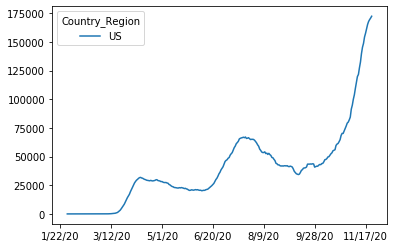

In [6]:
# U.S. daily incident case numbers plot

df.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().plot()
print(df.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().iloc[-1])

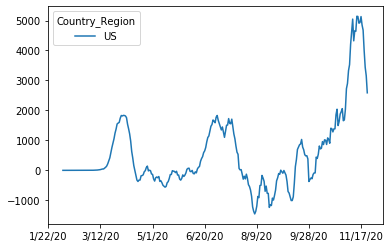

In [7]:
# derivative of daily cases
df.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().diff().rolling(7).mean().plot()

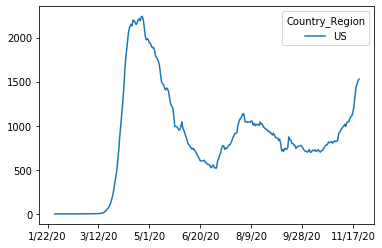

In [8]:
# U.S. daily covid deaths

deathf.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().plot()
#deathf.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().iloc[-5:]

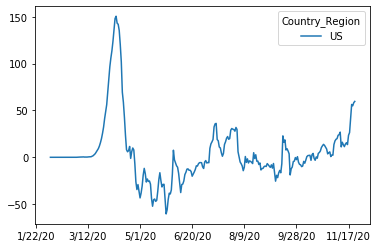

In [9]:
# derivative of daily deaths
deathf.groupby("Country_Region")[date_cols].sum().T.diff().rolling(7).mean().diff().rolling(7).mean().plot()

In [10]:
#url_ty="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
Glbl_conf = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
Glbl_rec = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
Glbl_death = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

g_conf_raw = pd.read_csv(Glbl_conf, error_bad_lines = False)
g_rec_raw = pd.read_csv(Glbl_rec, error_bad_lines = False)
g_death_raw = pd.read_csv(Glbl_death, error_bad_lines = False)

g_conf = g_conf_raw.groupby("Country/Region").sum()[date_cols]
g_rec = g_rec_raw.groupby("Country/Region").sum()[date_cols]
g_death = g_death_raw.groupby("Country/Region").sum()[date_cols]

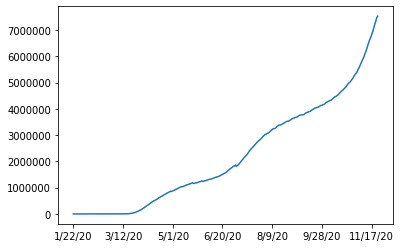

In [11]:
#find duplicates and find non duplicates of lists

#no_dupes = [x for n, x in enumerate(a) if x not in a[:n]] #print no_dupes # [[1], [2], [3], [5]]
#dupes = [x for n, x in enumerate(a) if x in a[:n]] #print dupes # [[1], [3]]
active_cases = g_conf-g_rec-g_death
active_cases.loc['US'].plot()

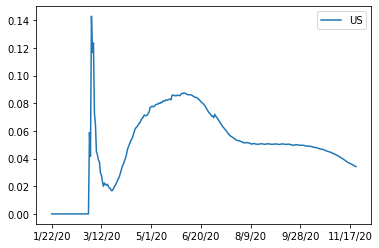

In [12]:
#Lethality measure

pd.DataFrame(g_death.loc['US']/active_cases.loc['US']).plot()

Cross correlation of cases and deaths

In [16]:
#cross correlation to find time lag between cases and deaths

us_daily_case_array = df.groupby("Country_Region")[date_cols].sum().T.diff()[1:].rolling(7).mean().fillna(0).to_numpy()[:,0] #week ave
us_daily_case_array = us_daily_case_array/np.linalg.norm(us_daily_case_array)
us_daily_death_array = deathf.groupby("Country_Region")[date_cols].sum().T.diff()[1:].rolling(7).mean().fillna(0).to_numpy()[:,0] #week ave
us_daily_death_array = us_daily_death_array/np.linalg.norm(us_daily_death_array)

#see if lack of testing at the beginning of pandemic has thrown off cross-corr
#us_daily_case_array = us_daily_case_array[140:]
#us_daily_death_array = us_daily_death_array[140:]

Max correlation is at lag 0 
Correlation is 0.37


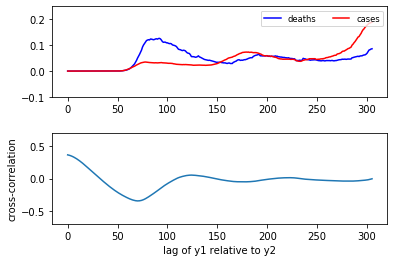

In [19]:
# from following https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html
# correlation is strongest without any lag. This is a suprise to me. I would have expection correlation to be greatest
# with a lag of a couple weeks as a proportion of those who got sick then died

subset = 0 #0 equals the whole series of data
x = np.arange(subset,len(us_daily_case_array))
y1 = us_daily_death_array[subset:]
y2 = us_daily_case_array[subset:]
npts = len(y1)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (npts * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='deaths')
ax.plot(x, y2, 'r', label='cases')
ax.set_ylim(-.1, .25)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags[npts-1:], ccor[npts-1:])
ax.set_ylim(-.7, .7)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = np.argmax(ccor[npts-1:])
maxcorr = np.max(ccor[npts-1:])
print("Max correlation is at lag", maxlag,"\nCorrelation is", round(maxcorr,2)) 

In [ ]:
#Average US state daily confirmed cases/deaths as a percent of population

#confirmed_norm = confirmed_norm[np.isfinite(confirmed_norm).all(1)]
#pd.DataFrame(confirmed_norm.mean().T.diff().rolling(7).mean()).rename(columns={0: 'US state ave'}).plot()
#pd.DataFrame(death_norm.mean().diff().rolling(7).mean()).rename(columns={0: 'US state ave'}).plot()

8 week cumulative cases

In [20]:
#Average US state vs Onondaga, NY vs Cumberland, Maine 
#comparison metric is 8 week cumulative incident cases as a percent of population
#this metric represents a liberal approximation of active cases
import functools

us =pd.DataFrame(confirmed_norm.mean().T.diff().rolling(7*8).sum().rename('US state ave'))
ari = pd.DataFrame(counties_norm[(counties_norm["Province_State"] == "New York") & (counties_norm["Admin2"] == "Monroe")][date_cols].T.diff().rolling(7*8).sum().rename(columns={1927: 'Rochester'}))
sadie = pd.DataFrame(counties_norm[(counties_norm["Province_State"] == "New York") & (counties_norm["Admin2"] == "Onondaga")][date_cols].T.diff().rolling(7*8).sum().rename(columns={1933: 'Syracuse'}))
gang = counties_norm[(counties_norm["Province_State"] == "Maine") & (counties_norm["Admin2"] == "Penobscot")][date_cols].T.diff().rolling(7*8).sum().rename(columns={1229: 'Penobscot'})
me = counties_norm[(counties_norm["Province_State"] == "Maine") & (counties_norm["Admin2"] == "Cumberland")][date_cols].T.diff().rolling(7*8).sum().rename(columns={1221: 'Cumberland'})

data = [us, ari, sadie, gang, me]
merged = functools.reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data) #, on=['date'], how='outer'

C:\Users\avid\anaconda3\lib\site-packages\pandas\core\algorithms.py:1926: RuntimeWarning:

invalid value encountered in subtract



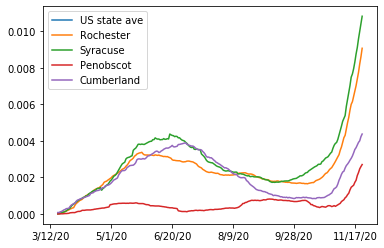

In [21]:
merged.plot()
#plt.title("Sum of new cases in past 8 weeks")
#plt.ylabel("Active cases proxy, % of pop")

R approximation day n+1's cases divided by day n's active cases

In [22]:
#active case approx
state_daily_cases = confirmed_norm.T.diff()[63:]
active_case_approx = confirmed_norm.T.diff().rolling(7*9).sum()[63:]

In [23]:
R_approx = pd.DataFrame(np.zeros([len(state_daily_cases)-1,len(state_daily_cases.columns)]))
for j in range(len(state_daily_cases.columns)):
    for i in range(len(state_daily_cases)-1):
        R_approx.iloc[i,j]=state_daily_cases.iloc[i+1,j]/active_case_approx.iloc[i,j]
R_approx.columns=state_daily_cases.columns
R_approx.dropna( axis=1, how="any", thresh=None, inplace=True)
R_approx=R_approx.rolling(7).mean()[6:].T

C:\Users\avid\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\avid\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in double_scalars



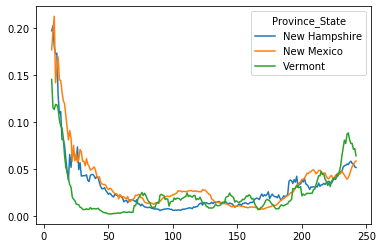

In [24]:
R_approx[(R_approx.iloc[:,-1]>.05)].T.plot()

Maine & NY visualizations

In [25]:
Maine = counties_norm[counties_norm["Province_State"] == "Maine"].set_index("Admin2")

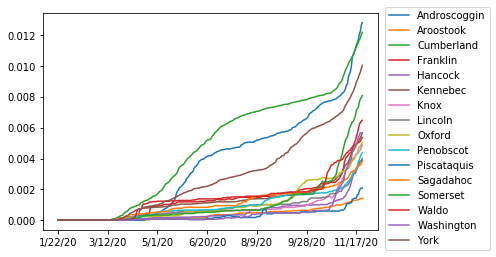

In [28]:
# total cases percent of pop 

Maine[date_cols].T.plot().legend(loc='upper right', bbox_to_anchor=(1.35, 1.05))

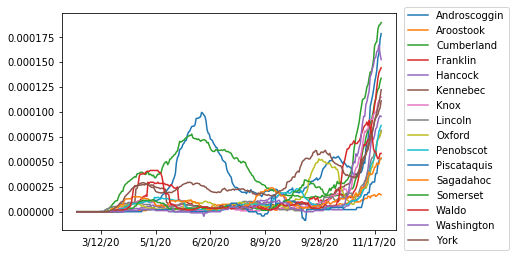

In [29]:
# daily incident cases as a percent of pop

Maine[date_cols].T.diff().rolling(28).mean().plot().legend(loc='upper right', bbox_to_anchor=(1.35, 1.05))

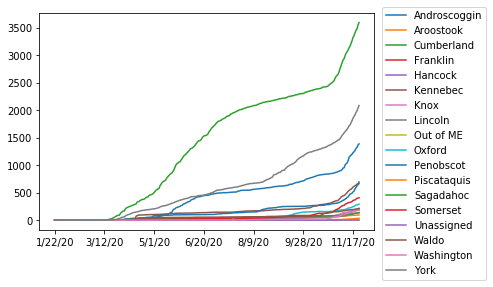

In [30]:
#raw total case count

Maine = counties[counties["Province_State"] == "Maine"].set_index("Admin2")
Maine[date_cols].T.plot().legend(loc='upper right', bbox_to_anchor=(1.35, 1.05))

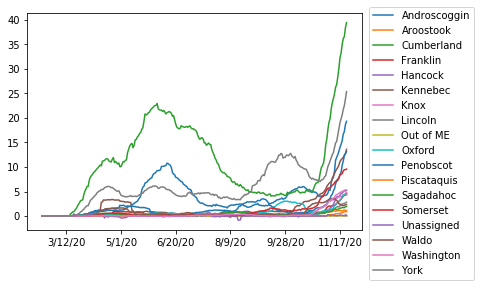

In [31]:
#raw daily incident case count

Maine[date_cols].T.diff().rolling(28).mean().plot().legend(loc='upper right', bbox_to_anchor=(1.35, 1.05))

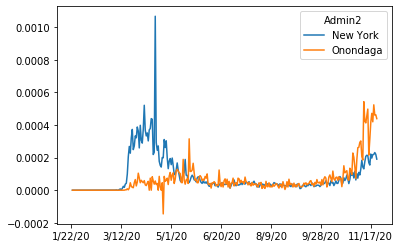

In [33]:
#compare 2 counties daily incident cases as a percent of population

counties_norm[(counties_norm["Province_State"] == "New York") & ((counties_norm["Admin2"] == "Onondaga") |(counties_norm["Admin2"] == "New York"))].set_index("Admin2")[date_cols].T.diff().plot()
